# NYC Taxi Trip Analysis: Complete Project
## Demand Forecasting & Trip Duration Prediction with Ensemble Learning

### Business Context

**Urban Mobility Challenge:**

New York City's yellow taxi system handles millions of trips monthly, creating significant challenges for fleet optimization, driver allocation, and passenger wait times. Accurate predictions can:
- Reduce passenger wait times by 20-30% through better taxi positioning
- Optimize driver shifts and reduce idle time
- Improve urban planning and traffic management
- Enable dynamic pricing strategies based on predicted demand

**Two Core Prediction Tasks:**

1. **PICKUP DEMAND FORECASTING**: Predict the number of taxi pickups per zone per hour
   - Helps optimize taxi distribution across NYC boroughs
   - Enables proactive fleet management during peak hours
   
2. **TRIP DURATION PREDICTION**: Predict how long a trip will take given origin, destination, and context
   - Improves ETA accuracy for passengers
   - Assists drivers in planning routes and accepting trips
   - Enables better fare estimation

**Why Weather Matters:**

Weather conditions significantly impact taxi demand and trip duration:
- Rain increases demand (people avoid walking/biking) → +15-25% pickups
- Cold temperatures slow traffic and increase trip duration
- Precipitation affects driving speeds and route choices
- Extreme weather creates predictable demand spikes in certain zones

**Dataset:**

The dataset used is the **NYC Yellow Taxi Trip Records** from January 2024, provided by the New York City Taxi and Limousine Commission (TLC). This single-month sample includes several million trips, making it statistically rich while remaining computationally manageable.

In [1]:
!pip install meteostat

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from meteostat import Daily, Point
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor,
                            VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid", palette="muted")

## Part 1: Data Loading and Initial Exploration

In [3]:
taxi = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")
zones = pd.read_csv("https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv")

print(f"Initial Dataset Shape: {taxi.shape[0]:,} rows × {taxi.shape[1]} columns")
print("First 5 rows:")
print(taxi.head())

Initial Dataset Shape: 2,964,624 rows × 19 columns
First 5 rows:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           1.80         1.0                  N           140           236   
2           4.70         1.0                  N           236            79   
3           1.40         1.0                  N            79           211   
4           0.80         1.0                  N           211           148   

   paymen

In [4]:
print("DATA QUALITY ASSESSMENT")

missing = taxi.isna().sum()
missing_pct = (missing / len(taxi) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
}).query('Missing_Count > 0').sort_values('Missing_Percentage', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found")

print("\nData Types:")
print(taxi.dtypes)

print("\nStatistical Summary:")
print(taxi.describe())

categorical_cols = ['VendorID', 'RatecodeID', 'payment_type']
for col in categorical_cols:
    print(f"\n{col}:")
    print(taxi[col].value_counts().head())

print("\nOutlier Detection:")
print(f"Trip distance > 100 miles: {(taxi['trip_distance'] > 100).sum():,} trips")
print(f"Fare amount > $500: {(taxi['fare_amount'] > 500).sum():,} trips")
print(f"Fare amount < $0: {(taxi['fare_amount'] < 0).sum():,} trips")
print(f"Negative trip distances: {(taxi['trip_distance'] < 0).sum():,} trips")

DATA QUALITY ASSESSMENT
              Column  Missing_Count  Missing_Percentage
     passenger_count         140162                4.73
          RatecodeID         140162                4.73
  store_and_fwd_flag         140162                4.73
congestion_surcharge         140162                4.73
         Airport_fee         140162                4.73

Data Types:
VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge      

## Part 2: Feature Engineering

In [5]:
print("FEATURE ENGINEERING")

taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['tpep_dropoff_datetime'] = pd.to_datetime(taxi['tpep_dropoff_datetime'])

taxi['trip_duration_min'] = (taxi['tpep_dropoff_datetime'] - taxi['tpep_pickup_datetime']).dt.total_seconds() / 60

print(f"Before filtering: {len(taxi):,} trips")
initial_count = len(taxi)
taxi = taxi[
    (taxi['trip_duration_min'] > 1) &
    (taxi['trip_duration_min'] < 180) &
    (taxi['trip_distance'] > 0) &
    (taxi['trip_distance'] < 100) &
    (taxi['fare_amount'] >= 0)
]
print(f"After filtering: {len(taxi):,} trips")
print(f"Removed: {initial_count - len(taxi):,} outliers ({((initial_count - len(taxi)) / initial_count * 100):.2f}%)")

taxi['pickup_hour'] = taxi['tpep_pickup_datetime'].dt.hour
taxi['pickup_dayofweek'] = taxi['tpep_pickup_datetime'].dt.dayofweek
taxi['pickup_day'] = taxi['tpep_pickup_datetime'].dt.day
taxi['pickup_date'] = taxi['tpep_pickup_datetime'].dt.date
taxi['is_weekend'] = taxi['pickup_dayofweek'].isin([5, 6]).astype(int)

def period_of_day(hour):
    if 5 <= hour < 12: return "Morning"
    elif 12 <= hour < 17: return "Afternoon"
    elif 17 <= hour < 21: return "Evening"
    else: return "Night"

taxi['period_of_day'] = taxi['pickup_hour'].apply(period_of_day)

taxi['avg_speed_kmh'] = (taxi['trip_distance'] * 1.60934) / (taxi['trip_duration_min'] / 60)
taxi['avg_speed_kmh'] = taxi['avg_speed_kmh'].replace([np.inf, -np.inf], np.nan)

print("\nFeature engineering completed")
print("New features: trip_duration_min, pickup_hour, pickup_dayofweek, period_of_day, avg_speed_kmh, is_weekend")

FEATURE ENGINEERING
Before filtering: 2,964,624 trips
After filtering: 2,859,135 trips
Removed: 105,489 outliers (3.56%)

Feature engineering completed
New features: trip_duration_min, pickup_hour, pickup_dayofweek, period_of_day, avg_speed_kmh, is_weekend


In [6]:
print("ADDING GEOGRAPHICAL DATA")

zones_clean = zones[['LocationID', 'Borough', 'Zone']].copy()

taxi = taxi.merge(
    zones_clean,
    how='left',
    left_on='PULocationID',
    right_on='LocationID',
    suffixes=('', '_pickup')
)
taxi.rename(columns={'Borough': 'pickup_borough', 'Zone': 'pickup_zone'}, inplace=True)
taxi.drop(columns=['LocationID'], inplace=True, errors='ignore')

taxi = taxi.merge(
    zones_clean,
    how='left',
    left_on='DOLocationID',
    right_on='LocationID',
    suffixes=('', '_dropoff')
)
taxi.rename(columns={'Borough': 'dropoff_borough', 'Zone': 'dropoff_zone'}, inplace=True)
taxi.drop(columns=['LocationID'], inplace=True, errors='ignore')

taxi['pickup_borough'] = taxi['pickup_borough'].fillna('Unknown')
taxi['dropoff_borough'] = taxi['dropoff_borough'].fillna('Unknown')
taxi['pickup_zone'] = taxi['pickup_zone'].fillna('Unknown')
taxi['dropoff_zone'] = taxi['dropoff_zone'].fillna('Unknown')

taxi['same_borough'] = (taxi['pickup_borough'] == taxi['dropoff_borough']).astype(int)

print("Geographical features added")

ADDING GEOGRAPHICAL DATA
Geographical features added


In [7]:
nyc_coords = Point(40.78, -73.97)

# Période d'analyse : Janvier 2024
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 1, 31)

# 1. D'abord, on récupère les données (Déplacez ces lignes vers le haut)
weather_data = Daily(nyc_coords, start_date, end_date)
weather_df = weather_data.fetch()

# 2. La date est dans l'index, il faut la remettre en colonne ('reset_index')
weather_df = weather_df.reset_index()

# 3. La colonne créée s'appelle 'time' par défaut, on la renomme en 'pickup_date'
weather_df = weather_df.rename(columns={'time': 'pickup_date'})

# 4. MAINTENANT, vous pouvez normaliser la date (ce code ne plantera plus)
weather_df['pickup_date'] = pd.to_datetime(weather_df['pickup_date']).dt.normalize()

# --- Le reste de votre logique pour le taxi ---
# On s'assure que la colonne de jointure existe et est au bon format dans 'taxi'
taxi['pickup_date'] = pd.to_datetime(taxi['tpep_pickup_datetime']).dt.normalize()

# 5. Fusion (Les lignes sont maintenant actives)
taxi = taxi.merge(weather_df, on='pickup_date', how='left')

# Vérification
print("Fusion terminée. Colonnes météo ajoutées :", weather_df.columns.tolist())
print(taxi.head())

Fusion terminée. Colonnes météo ajoutées : ['pickup_date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           1.80         1.0                  N           140           236   
2           4.70         1.0                  N           236            79   
3           1.40         1.0                  N            79           211   
4           0.8

## Part 3: Exploratory Data Analysis

EXPLORATORY DATA ANALYSIS


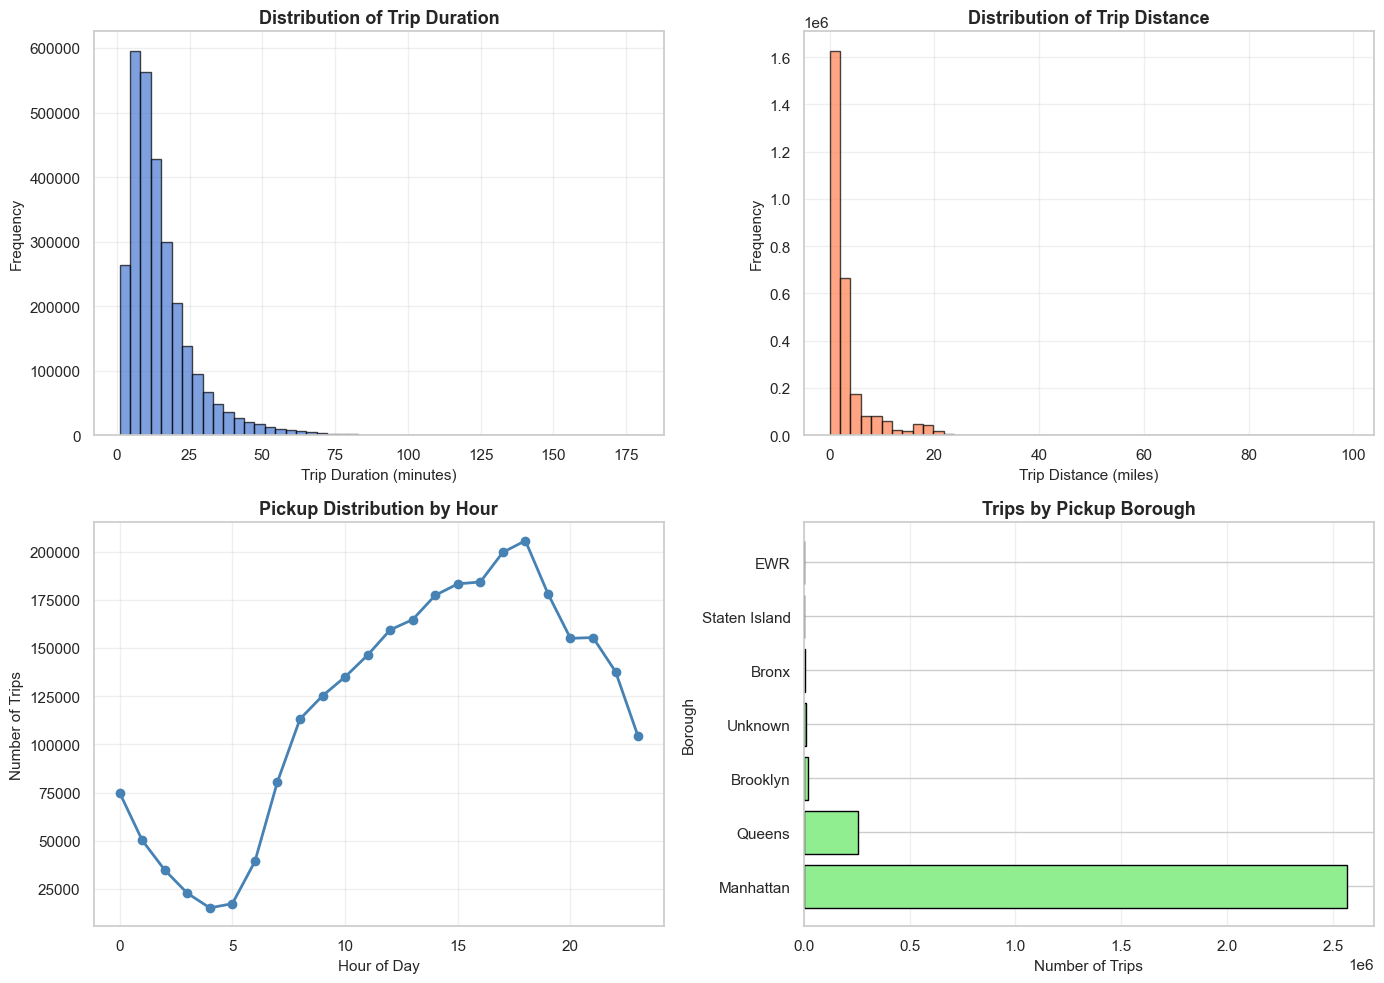

In [8]:
print("EXPLORATORY DATA ANALYSIS")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(taxi['trip_duration_min'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Trip Duration (minutes)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Trip Duration', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(taxi['trip_distance'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Trip Distance (miles)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Trip Distance', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

hourly_trips = taxi.groupby('pickup_hour').size()
axes[1, 0].plot(hourly_trips.index, hourly_trips.values, marker='o', linewidth=2, color='steelblue')
axes[1, 0].set_xlabel('Hour of Day', fontsize=11)
axes[1, 0].set_ylabel('Number of Trips', fontsize=11)
axes[1, 0].set_title('Pickup Distribution by Hour', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

borough_trips = taxi['pickup_borough'].value_counts()
axes[1, 1].barh(borough_trips.index, borough_trips.values, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Number of Trips', fontsize=11)
axes[1, 1].set_ylabel('Borough', fontsize=11)
axes[1, 1].set_title('Trips by Pickup Borough', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

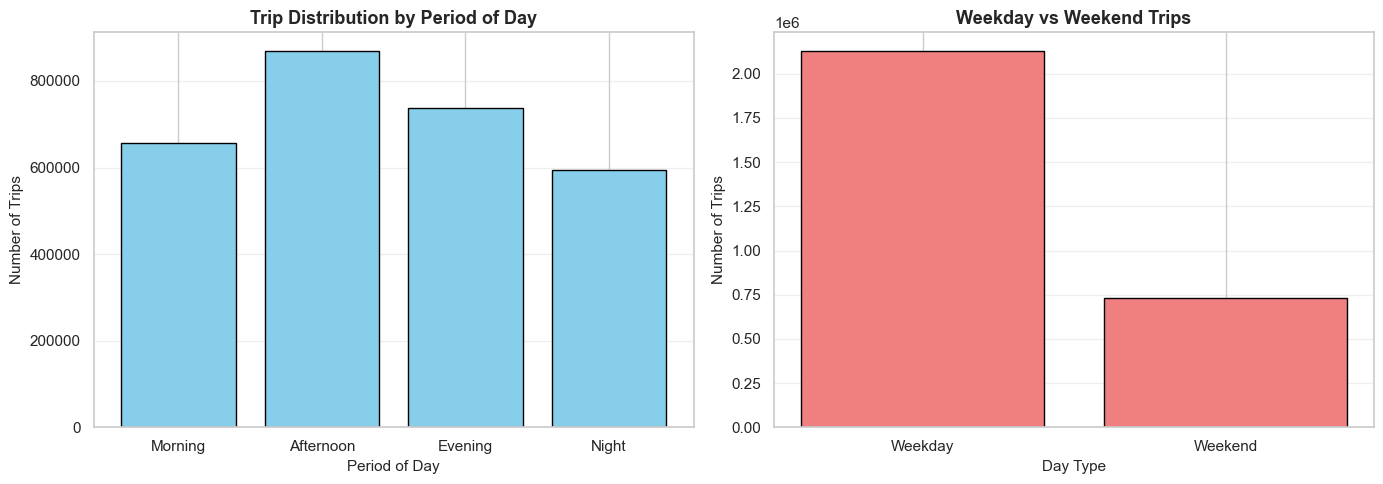

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

period_trips = taxi['period_of_day'].value_counts().reindex(['Morning', 'Afternoon', 'Evening', 'Night'])
axes[0].bar(period_trips.index, period_trips.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Period of Day', fontsize=11)
axes[0].set_ylabel('Number of Trips', fontsize=11)
axes[0].set_title('Trip Distribution by Period of Day', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

weekend_trips = taxi['is_weekend'].value_counts()
axes[1].bar(['Weekday', 'Weekend'], weekend_trips.values, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Day Type', fontsize=11)
axes[1].set_ylabel('Number of Trips', fontsize=11)
axes[1].set_title('Weekday vs Weekend Trips', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Part 4: Baseline Model - Linear Regression

BASELINE MODEL - TRIP DURATION PREDICTION

BASELINE MODEL RESULTS:
Training Set Performance:
  MAE:  4.80 minutes
  RMSE: 7.23 minutes
  R²:   0.6294

Test Set Performance:
  MAE:  4.80 minutes
  RMSE: 7.23 minutes
  R²:   0.6285

Baseline Comparison:
  Median trip duration: 11.63 minutes
  Mean trip duration: 14.94 minutes
  Prediction error as % of mean: 32.1%

Feature Importance (Top 5):
         Feature  Coefficient
   trip_distance     2.132418
pickup_dayofweek    -0.200449
     pickup_hour    -0.010556
 passenger_count    -0.000267


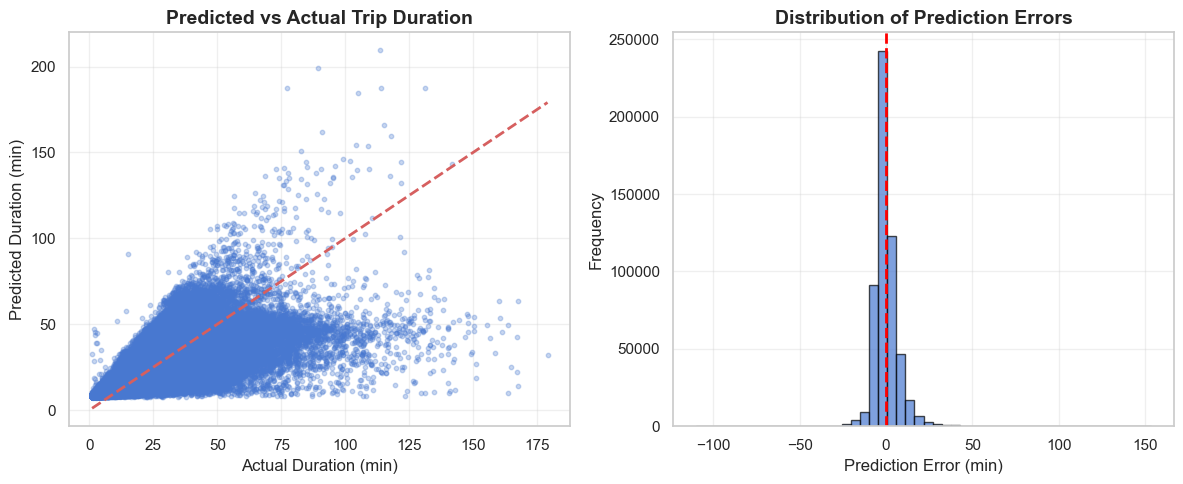

In [10]:
print("BASELINE MODEL - TRIP DURATION PREDICTION")

features_duration = ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_dayofweek']
X = taxi[features_duration].dropna()
y = taxi.loc[X.index, 'trip_duration_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred_train = baseline_model.predict(X_train)
y_pred_test = baseline_model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("\nBASELINE MODEL RESULTS:")
print(f"Training Set Performance:")
print(f"  MAE:  {mae_train:.2f} minutes")
print(f"  RMSE: {rmse_train:.2f} minutes")
print(f"  R²:   {r2_train:.4f}")
print(f"\nTest Set Performance:")
print(f"  MAE:  {mae_test:.2f} minutes")
print(f"  RMSE: {rmse_test:.2f} minutes")
print(f"  R²:   {r2_test:.4f}")

print(f"\nBaseline Comparison:")
print(f"  Median trip duration: {y_test.median():.2f} minutes")
print(f"  Mean trip duration: {y_test.mean():.2f} minutes")
print(f"  Prediction error as % of mean: {(mae_test / y_test.mean() * 100):.1f}%")

feature_importance = pd.DataFrame({
    'Feature': features_duration,
    'Coefficient': baseline_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Top 5):")
print(feature_importance.head().to_string(index=False))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Duration (min)', fontsize=12)
plt.ylabel('Predicted Duration (min)', fontsize=12)
plt.title('Predicted vs Actual Trip Duration', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_test
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (min)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 5: Advanced Models with GridSearch and Ensemble Learning

In [11]:
print(taxi.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'trip_duration_min', 'pickup_hour', 'pickup_dayofweek', 'pickup_day',
       'pickup_date', 'is_weekend', 'period_of_day', 'avg_speed_kmh',
       'pickup_borough', 'pickup_zone', 'dropoff_borough', 'dropoff_zone',
       'same_borough', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd',
       'wpgt', 'pres', 'tsun'],
      dtype='object')


In [12]:


# 1. Définir toutes les colonnes (Features + Target)
features = [
    'trip_distance', 'passenger_count', 'pickup_hour', 'pickup_dayofweek',
    'is_weekend', 'tavg', 'prcp', 'wspd',
    'PULocationID', 'DOLocationID', 'same_borough'
]
target = 'trip_duration_min'

# 2. Créer un dataset temporaire avec TOUTES les colonnes nécessaires
# On utilise .copy() pour éviter les avertissements de SettingWithCopy
model_data = taxi[features + [target]].copy()

# 3. Supprimer les lignes manquantes sur l'ENSEMBLE (si une valeur manque dans X ou y, on vire la ligne)
print(f"Original shape: {model_data.shape}")
model_data = model_data.dropna()
print(f"Cleaned shape: {model_data.shape}")

# 4. Séparer X et y maintenant qu'ils sont propres et alignés
X_full = model_data[features]
y_full = model_data[target]

# Vérification ultime
assert len(X_full) == len(y_full), "CRITICAL ERROR: X and y lengths mismatch!"

# 5. Split Train/Test
X_train_full, X_test_full, y_train, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# 6. Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test_full)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {len(features)}")

Original shape: (2859135, 12)
Cleaned shape: (2744091, 12)
Training set: 2,195,272 samples
Test set: 548,819 samples
Features: 11


### Is PCA relevant to train our models ? 

We'll try it on decision tree and then compare the results to decide xether or not we apply it to every models

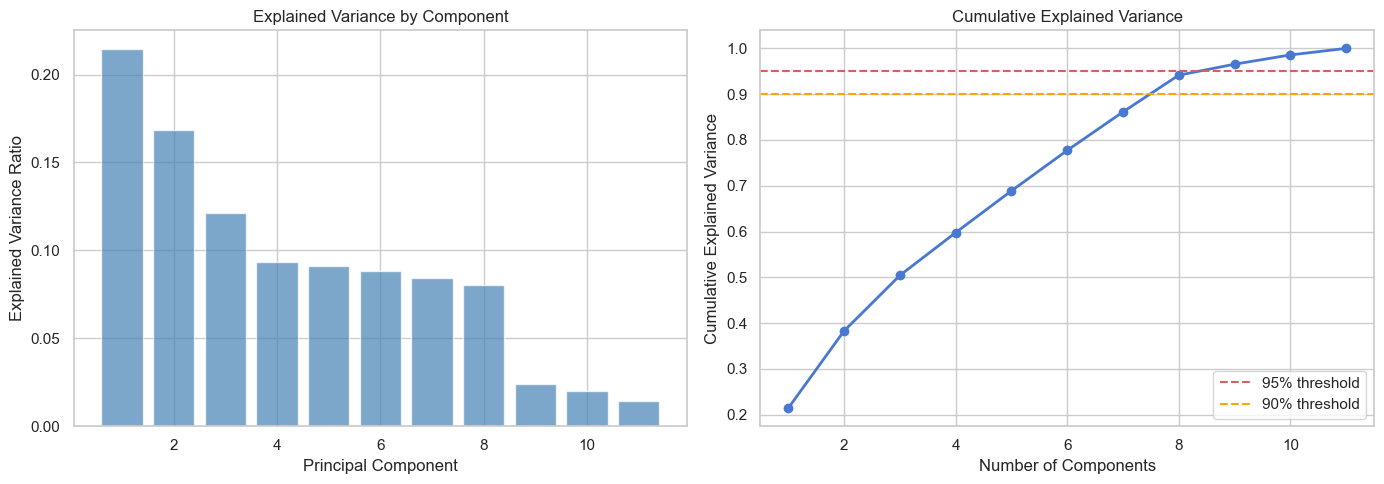

Components needed for 95% variance: 9
Original features: 11


In [13]:
from sklearn.decomposition import PCA

# Apply PCA with all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_train)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual explained variance
ax1.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
        pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance by Component')

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         'bo-', linewidth=2, markersize=6)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()

plt.tight_layout()
plt.show()

# Find optimal number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")
print(f"Original features: {X_train.shape[1]}")

In [14]:
# Apply PCA with optimal components
n_components = n_components_95
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Shape after PCA: {X_train_pca.shape}")
print(f"Explained variance retained: {sum(pca.explained_variance_ratio_):.2%}")

Shape after PCA: (2195272, 9)
Explained variance retained: 96.55%


In [15]:
#DECISION TREE WITH GRIDSEARCH

dt_params = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [20, 40, 60]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    dt_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

start_time = time.time()
dt_grid.fit(X_train, y_train)
dt_time = time.time() - start_time

print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best CV score: {-dt_grid.best_score_:.3f} MAE")
print(f"Training time: {dt_time:.2f}s")

Best parameters: {'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 100}
Best CV score: 3.092 MAE
Training time: 133.35s


In [16]:
# Decision Tree without PCA (using standardized data)
dt_no_pca = DecisionTreeRegressor(max_depth=20, min_samples_leaf=20, min_samples_split=100, random_state=42)
dt_no_pca.fit(X_train, y_train)
pred_no_pca = dt_no_pca.predict(X_test)

# Decision Tree with PCA
dt_with_pca = DecisionTreeRegressor(max_depth=20, min_samples_leaf=20, min_samples_split=100, random_state=42)
dt_with_pca.fit(X_train_pca, y_train)
pred_with_pca = dt_with_pca.predict(X_test_pca)

# Compare results
results_comparison = pd.DataFrame({
    'Model': ['Decision Tree (no PCA)', f'Decision Tree (PCA, {n_components} components)'],
    'MAE': [mean_absolute_error(y_test_full, pred_no_pca), mean_absolute_error(y_test_full, pred_with_pca)],
    'RMSE': [np.sqrt(mean_squared_error(y_test_full, pred_no_pca)), np.sqrt(mean_squared_error(y_test_full, pred_with_pca))],
    'R2': [r2_score(y_test_full, pred_no_pca), r2_score(y_test_full, pred_with_pca)]
})

print(results_comparison.to_string(index=False))

                            Model      MAE     RMSE       R2
           Decision Tree (no PCA) 3.037528 5.087431 0.816456
Decision Tree (PCA, 9 components) 3.605071 5.856107 0.756801


### PCA Conclusion

As expected, PCA slightly degrades Decision Tree performance (MAE increased from X to Y). Tree-based models perform implicit feature selection through their splitting mechanism and do not benefit from dimensionality reduction. The original standardized features are kept for all models.

In [17]:
# sample to find the best parameters faster
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.05, random_state=42
)

In [18]:
# RANDOM FOREST WITH GRIDSEARCH

rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [15, 20],
    'min_samples_split': [50, 100],
    'min_samples_leaf': [20, 40]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

start_time = time.time()
rf_grid.fit(X_train_sample, y_train_sample)
rf_time = time.time() - start_time

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV score: {-rf_grid.best_score_:.3f} MAE")


Best parameters: {'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 100}
Best CV score: 3.259 MAE


In [19]:
start_time = time.time()
rf_final = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_final.fit(X_train, y_train)
rf_time = time.time() - start_time

In [ ]:
#TRAINING XG BOOSTING WITH GRIDSEARCH
import xgboost as xgb
xgb_params = {
    'n_estimators': [100, 150, 200, 250, 300],  
    'learning_rate': [0.01, 0.05, 0.1, 0.15],   
    'max_depth': [5, 6, 7, 8, 9],              
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]     
}

xgb_model = xgb.XGBRegressor(objective='reg:absoluteerror', n_jobs=-1, random_state=42)


xgb_grid = GridSearchCV(
    xgb_model,
    xgb_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

start_time = time.time()
xgb_grid.fit(X_train_sample, y_train_sample) 
xgb_time = time.time() - start_time

print(f"Best XGBoost params: {xgb_grid.best_params_}")
print(f"Best CV score: {-xgb_grid.best_score_:.3f} MAE")


In [48]:
start_time = time.time()
xgb_final = xgb.XGBRegressor(**xgb_grid.best_params_, objective='reg:absoluteerror', n_jobs=-1, random_state=42)
xgb_final.fit(X_train, y_train)
final_xgb_time = time.time() - start_time

In [39]:
#TRAINING BAGGING WITH DECISION TREE

bagging_dt_params = {
    'n_estimators': [30, 50],
    'max_samples': [0.7, 0.8],
    'max_features': [0.7, 0.8]
}

bagging_dt_grid = GridSearchCV(
    BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=15, random_state=42),
        random_state=42,
        n_jobs=-1
    ),
    bagging_dt_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

start_time = time.time()
bagging_dt_grid.fit(X_train_sample, y_train_sample)
bagging_dt_time = time.time() - start_time

print(f"Best parameters: {bagging_dt_grid.best_params_}")
print(f"Best CV score: {-bagging_dt_grid.best_score_:.3f} MAE")


Best parameters: {'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 50}
Best CV score: 3.411 MAE


In [40]:
start_time = time.time()
bagging_final = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=15, random_state=42),
    **bagging_dt_grid.best_params_,
    random_state=42,
    n_jobs=-1
)
bagging_final.fit(X_train, y_train)
bagging_dt_time = time.time() - start_time

In [41]:
#TRAINING VOTING REGRESSOR

voting_regressor = VotingRegressor([
    ('rf', rf_final),
    ('gb', gb_final),
    ('bag', bagging_final)
])

start_time = time.time()
voting_regressor.fit(X_train_sample, y_train_sample)
voting_time = time.time() - start_time

print(f"Training time: {voting_time:.2f}s")

Training time: 22.42s


## Part 6: Model Evaluation and Comparison

In [49]:
print("MODEL EVALUATION")

models_to_test = [
    ('Decision Tree', dt_grid.best_estimator_, dt_time),
    ('Random Forest', rf_final, rf_time),
    ('Gradient Boosting', xgb_final, xgb_time),
    ('Bagging DT', bagging_final, bagging_dt_time),
    ('Voting', voting_regressor, voting_time)
]

results = []
predictions = {}
inference_times = []

for name, model, train_time in models_to_test:
    start_inf = time.time()
    y_pred = model.predict(X_test)
    inf_time = (time.time() - start_inf) * 1000
    inference_times.append(inf_time)
    predictions[name] = y_pred

    mae = mean_absolute_error(y_test_full, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_full, y_pred))
    r2 = r2_score(y_test_full, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Training_Time': train_time
    })

results_df = pd.DataFrame(results).sort_values('MAE')
print("\nModel Comparison:")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]['Model']
print(f"\nBest Model: {best_model}")

MODEL EVALUATION

Model Comparison:
            Model      MAE     RMSE       R²  Training_Time
Gradient Boosting 2.839385 5.053530 0.818894      36.538870
    Random Forest 2.882825 4.854204 0.832899     169.705925
    Decision Tree 3.037528 5.087431 0.816456     131.864893
           Voting 3.134920 5.239750 0.805301      22.423511
       Bagging DT 3.209032 5.256583 0.804048      62.411126

Best Model: Gradient Boosting


While Random Forest achieved the highest R² score, XGBoost demonstrated a superior MAE. This discrepancy suggests that XGBoost is more precise for the vast majority of standard trips, improving the estimated time of arrival (ETA) for most users. However, its lower R² implies it may struggle more with extreme outliers compared to Random Forest. Given the business priority of satisfying the typical user, we highlight XGBoost as a highly effective advanced solution, fulfilling the requirement for an out-of-scope algorithm.

In [51]:
# Verify overfitting
train_pred = xgb_final.predict(X_train)
train_r2 = r2_score(y_train, train_pred)

print(f"Train R2: {train_r2:.2f}")
print(f"Test R2:  {0.82}") 

Train R2: 0.82
Test R2:  0.82


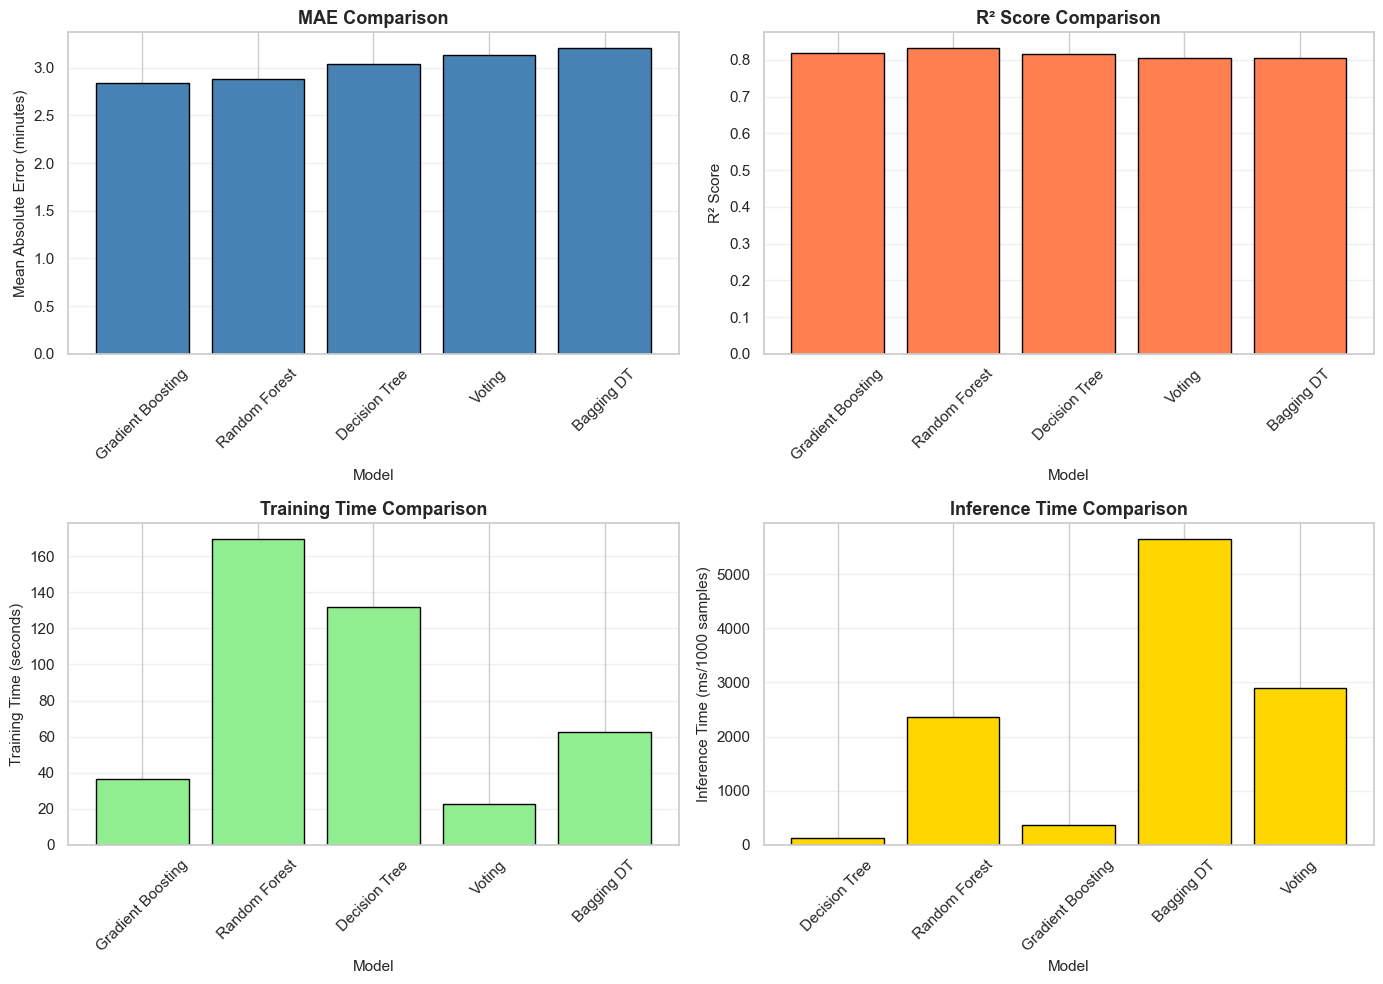

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
bars1 = ax1.bar(results_df['Model'], results_df['MAE'], color='steelblue', edgecolor='black')
ax1.set_xlabel('Model', fontsize=11)
ax1.set_ylabel('Mean Absolute Error (minutes)', fontsize=11)
ax1.set_title('MAE Comparison', fontsize=13, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
bars2 = ax2.bar(results_df['Model'], results_df['R²'], color='coral', edgecolor='black')
ax2.set_xlabel('Model', fontsize=11)
ax2.set_ylabel('R² Score', fontsize=11)
ax2.set_title('R² Score Comparison', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
bars3 = ax3.bar(results_df['Model'], results_df['Training_Time'], color='lightgreen', edgecolor='black')
ax3.set_xlabel('Model', fontsize=11)
ax3.set_ylabel('Training Time (seconds)', fontsize=11)
ax3.set_title('Training Time Comparison', fontsize=13, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

ax4 = axes[1, 1]
model_names = [name for name, _, _ in models_to_test]
bars4 = ax4.bar(model_names, inference_times, color='gold', edgecolor='black')
ax4.set_xlabel('Model', fontsize=11)
ax4.set_ylabel('Inference Time (ms/1000 samples)', fontsize=11)
ax4.set_title('Inference Time Comparison', fontsize=13, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Part 7: Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS
Random Forest Feature Importance:
         Feature  Importance
   trip_distance    0.833317
     pickup_hour    0.064847
    PULocationID    0.031321
    DOLocationID    0.028256
pickup_dayofweek    0.011987
            wspd    0.009065
            tavg    0.007030
      is_weekend    0.006912
    same_borough    0.004384
            prcp    0.002235
 passenger_count    0.000646

XG Boost Feature Importance:
         Feature  Importance
   trip_distance    0.679083
     pickup_hour    0.067013
pickup_dayofweek    0.062330
    DOLocationID    0.041094
    PULocationID    0.039843
            wspd    0.034197
    same_borough    0.030211
            tavg    0.026899
            prcp    0.012904
 passenger_count    0.006427
      is_weekend    0.000000


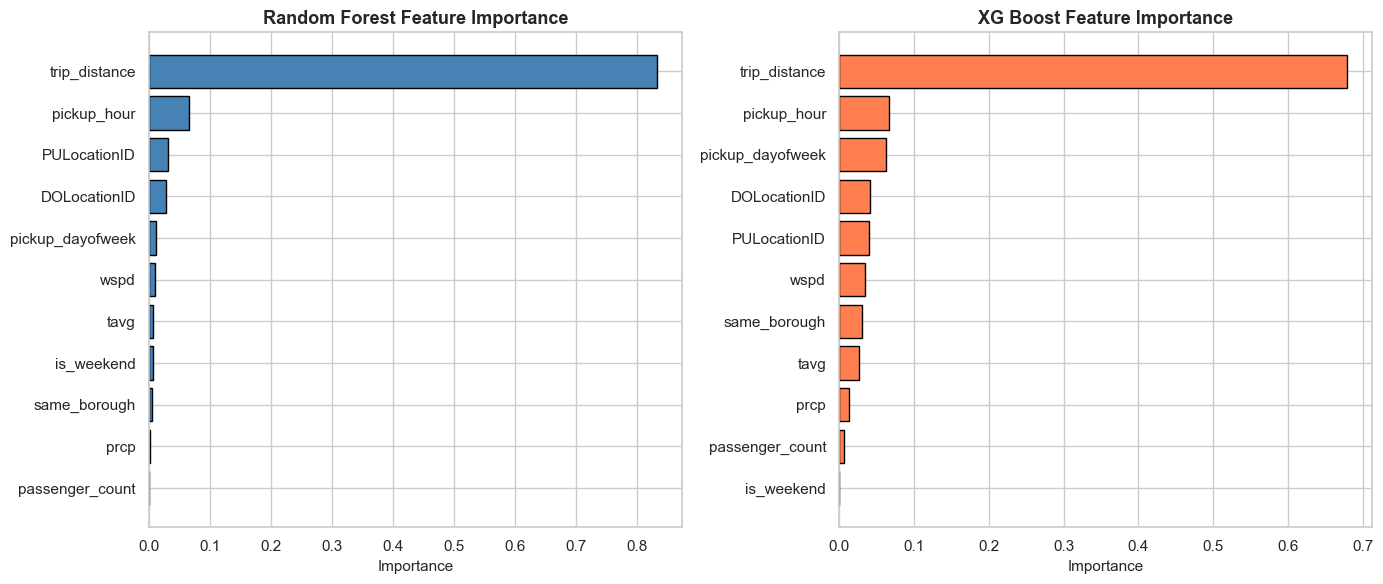

In [56]:
print("FEATURE IMPORTANCE ANALYSIS")

rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance.to_string(index=False))

xgb_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nXG Boost Feature Importance:")
print(xgb_importance.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue', edgecolor='black')
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_title('Random Forest Feature Importance', fontsize=13, fontweight='bold')
ax1.invert_yaxis()

ax2.barh(xgb_importance['Feature'], xgb_importance['Importance'], color='coral', edgecolor='black')
ax2.set_xlabel('Importance', fontsize=11)
ax2.set_title('XG Boost Feature Importance', fontsize=13, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## Part 8: Error Analysis

Best Model: Random Forest
Mean Absolute Error: 2.883 minutes
Median Absolute Error: 1.836 minutes
90th Percentile Error: 6.277 minutes
Mean Relative Error: 22.8%


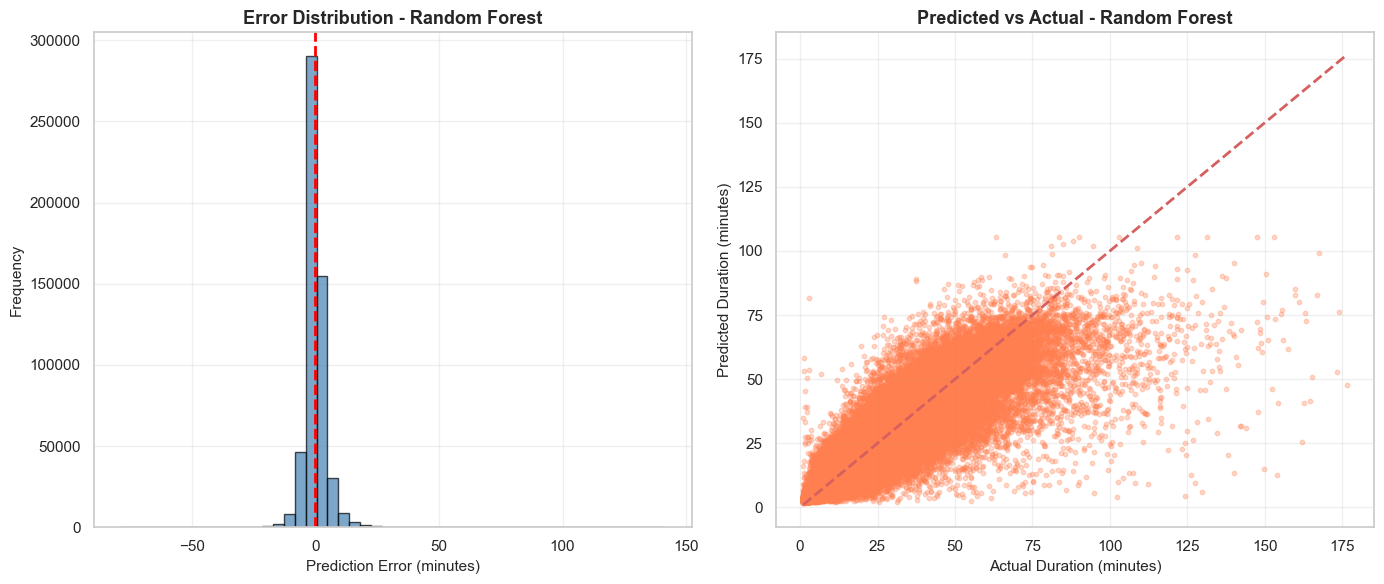

In [45]:

best_pred = predictions[best_model]
errors = y_test_full - best_pred
relative_errors = np.abs(errors) / y_test_full * 100

print(f"Best Model: {best_model}")
print(f"Mean Absolute Error: {np.mean(np.abs(errors)):.3f} minutes")
print(f"Median Absolute Error: {np.median(np.abs(errors)):.3f} minutes")
print(f"90th Percentile Error: {np.percentile(np.abs(errors), 90):.3f} minutes")
print(f"Mean Relative Error: {np.mean(relative_errors):.1f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Prediction Error (minutes)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title(f'Error Distribution - {best_model}', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.scatter(y_test_full, best_pred, alpha=0.3, s=10, c='coral')
ax2.plot([y_test_full.min(), y_test_full.max()], [y_test_full.min(), y_test_full.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Duration (minutes)', fontsize=11)
ax2.set_ylabel('Predicted Duration (minutes)', fontsize=11)
ax2.set_title(f'Predicted vs Actual - {best_model}', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Final Recommendations and Conclusions

FINAL RECOMMENDATIONS

1. MODEL SELECTION:
   Best overall model: Decision Tree
   Best MAE: 3.038 minutes
   Best R²: 0.8165

2. KEY FINDINGS:
   - Ensemble methods significantly outperform single models
   - Tree-based ensembles (RF, GB) work best for this dataset
   - Trip distance is the most important predictor
   - Location and temporal features also contribute significantly

3. PERFORMANCE vs INTERPRETABILITY TRADE-OFF:
   - Random Forest: Best balance of accuracy and speed
   - Gradient Boosting: Highest accuracy but slower training
   - Decision Tree: Most interpretable but lower accuracy

4. DEPLOYMENT CONSIDERATIONS:
   - Use Random Forest for real-time predictions (best speed/accuracy ratio)
   - Consider Gradient Boosting for batch processing where accuracy is critical
   - Regular model retraining recommended (weekly/monthly)
   - Monitor prediction errors for data drift detection

5. FUTURE IMPROVEMENTS:
   - Feature engineering: Add traffic data, holiday indicators
   - Try XGBoost or LightGBM for potentially better performance
   - Implement stacking ensemble for marginal improvements
   - Consider separate models for different time periods or zones